# Setup

In [1]:
%%capture
!pip install gensim
!pip install seaborn

In [2]:
import numpy as np
import sklearn
import gensim
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# constants and global variables
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/CIL/Dataset/{}'
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/CIL/Models/{}'
PROBABILITIES = '/content/drive/MyDrive/Colab Notebooks/CIL/Probabilities/{}'
PREDICTIONS = '/content/drive/MyDrive/Colab Notebooks/CIL/Predictions/{}'

# if set to true the trainig of the classifier models will be performed, otherwise the 
# models will be loaded from a file (if present)
is_train_enabled = True

# if set to true the trainig of the W2V model will be performed, otherwise the 
# model will be loaded from a file (if present)
is_w2v_train_enabled = False

# Read Preprocessed Data

In [5]:
def load_X_data(file_name):
  tweets = []
  with open(DATA_PATH.format(file_name), 'r', encoding='utf-8') as f:
      for line in f:
        tweets.append(line.rstrip().split())
  
  return np.array(tweets)

X_train = load_X_data("X_train_processed_full.txt")
X_test = load_X_data("X_test_processed_full.txt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


In [6]:
def load_y_data(file_name):
  labels = []
  with open(DATA_PATH.format(file_name), 'r', encoding='utf-8') as f:
      for line in f:
        labels.append(int(line.rstrip()))
  
  return np.array(labels)

y_train = load_y_data("y_train_full.txt")

In [7]:
for i in range(10):
  print(X_train[i])
  print(X_test[i])
  print(y_train[i])

['yes', 'even', 'realize', 'really', 'wanted', 'respond', 'want', 'buy', 'candy', 'something']
['sea', 'doo', 'pro', 'sea', 'scooter', 'sport', 'portable', 'sea', 'doo', 'seascootersave', 'air', 'stay', 'longer', 'water']
1
['bradly', 'james', 'lowrey', 'bestfriend', 'mean', 'alot', 'justthoughtidleteveryoneknow']
['shuck', 'well', 'work', 'week', 'come', 'cheer', 'oh', 'put', 'battery', 'calculator']
1
['mckleinusa', 'ashburn', 'series', 'leather', 'laptop', 'case', 'brown', 'clean', 'front', 'flap', 'design', 'secure', 'key', 'l']
['cant', 'stay', 'away', 'bug', 'thats', 'baby']
0
['next', 'time', 'ima', 'come', 'yo', 'class', 'nd', 'wake', 'wanted', 'come', 'get', 'hug', 'sleep']
['lol', 'im', 'perfectly', 'fine', 'contagious', 'anymore', 'lmao']
0
['trivial', 'pursuit', 'junior', 'second', 'edition', 'second', 'edition', 'junior', 'legendary', 'trivial', 'pursuit', 'game']
['whenever', 'fall', 'asleep', 'watching', 'tv', 'always', 'wake', 'headache']
0
['new', 'bbm', 'add', 'please

# W2V

In [8]:
from gensim.models import Word2Vec
import multiprocessing

# Count the number of cores in the computer
cores = multiprocessing.cpu_count()
print(cores)

# define the  W2V model
# TODO: experiment with different hyperparameters
w2v_model = Word2Vec(min_count=10,
                     window=3,
                     size=220,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=5,
                     workers=cores-1)

4


In [9]:
#  build the vocabulary table
if is_w2v_train_enabled:
  w2v_model.build_vocab(X_train)

In [10]:
if is_w2v_train_enabled:
  # train the model
  w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
  
  # since we don't plan to train the model any further, we use this function to make the model more memory efficient
  w2v_model.init_sims(replace=True)

  # save the model to a file so that it can be reused without being trained from scratch
  w2v_model.save(MODEL_PATH.format("word2vec.model"))

In [11]:
# load the trained model
w2v_model = Word2Vec.load(MODEL_PATH.format("word2vec.model"))

## Data Visualization

In [12]:
# check which words are most similar to
w2v_model.wv.most_similar(positive=["lol"])

[('lmao', 0.8945410251617432),
 ('tho', 0.8337392210960388),
 ('haha', 0.7463964223861694),
 ('lmfao', 0.7463028430938721),
 ('cuz', 0.7277502417564392),
 ('thats', 0.726454496383667),
 ('smh', 0.7036717534065247),
 ('yea', 0.701973021030426),
 ('hahaha', 0.7008428573608398),
 ('lmaoo', 0.6887624859809875)]

In [13]:
# check which words are most similar to
w2v_model.wv.most_similar(positive=["war"])

[('civil', 0.5958130955696106),
 ('boer', 0.5742727518081665),
 ('battle', 0.5579674243927002),
 ('napoleonic', 0.5507412552833557),
 ('wwii', 0.5501512289047241),
 ('iraq', 0.531488299369812),
 ('soviet', 0.5281188488006592),
 ('foyle', 0.5257067680358887),
 ('liberation', 0.5251907706260681),
 ('terror', 0.5241838693618774)]

In [14]:
# check which words are most similar to
w2v_model.wv.most_similar(positive=["email"])

[('mail', 0.60262131690979),
 ('message', 0.5876030325889587),
 ('dm', 0.5690068602561951),
 ('fanmail', 0.5362128019332886),
 ('send', 0.5336012840270996),
 ('hotmail', 0.525222659111023),
 ('gmail', 0.5165649652481079),
 ('inbox', 0.5092840790748596),
 ('address', 0.5064045190811157),
 ('submit', 0.5044562816619873)]

In [15]:
# return a number representing how much these two words are similar
w2v_model.wv.similarity("lol", 'haha')

0.7463964

In [16]:
# return the word that is least similar to the others in the list
w2v_model.wv.doesnt_match(['lol', 'haha', 'sad'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'sad'

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# draw words on a graph. Similar words  are close together in the graph.
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, w2v_model.vector_size), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


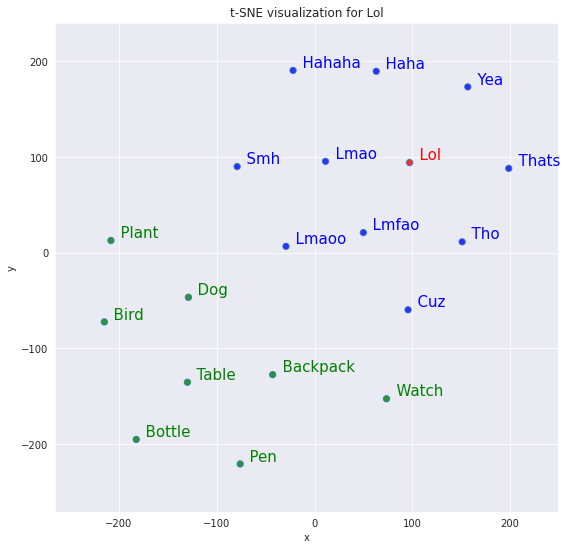

In [18]:
# visualize the 10 most similar words to doctor and 8 random words
tsnescatterplot(w2v_model, 'lol', ['dog', 'bird', 'table', 'watch', 'pen', 'plant', 'bottle', 'backpack'])

## Models
Apply standard machine learning models to the words embeddings that come out of W2V.

In [19]:
# given a list of sentences, for each sentence compute its emebedding by
# computing the embedding of each word in the sentence and then divide by the
# length of the phrase
def generate_senteces_embeddings(X):
  
  sentences_embedding = []
  # for each sentence in the set
  for sentence in X:
    sentence_length = len(sentence)
    # this variable will hold the sum of each word embedding in the current phrase
    sentence_embedding = np.zeros(w2v_model.vector_size)
    # for each word in the sentence
    for word in sentence:
      # embedding of the current word
      word_embedding = np.zeros(w2v_model.vector_size)

      # compute the embedding of the current word. This is not always possible as
      # not every word is in our dictionary. If this is not possible I simply discard
      # the word and decrese the sentence length by 1. 
      try:
        word_embedding = w2v_model.wv[word]
      except KeyError:
        sentence_length = sentence_length - 1
      
      sentence_embedding = sentence_embedding + word_embedding 
    
    # in our dataset there are some (very few) length 1 sentences
    # with one single word that is not part of the model vocabulary.
    # In order to prevent a divison by 0, this if stattement is necessary.
    if sentence_length == 0:
      sentence_embedding = np.zeros(w2v_model.vector_size)
    else:
      sentence_embedding = sentence_embedding / sentence_length

    # add the sentence embedding to the list that will be returned
    sentences_embedding.append(np.array(sentence_embedding))
  

  return sentences_embedding

X_train = np.array(generate_senteces_embeddings(X_train))
X_test = np.array(generate_senteces_embeddings(X_test))

### Multi Layer Perceptron

In [21]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(512, input_dim=w2v_model.vector_size, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

tensorflow.keras.utils.plot_model(model, show_shapes=True, dpi=64)
model.count_params()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               113152    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               3

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

file_path = MODEL_PATH.format("MLP_w2v.h5")
callbacks = [
             ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
             ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2),
             EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
             ]
if is_train_enabled:
  history = model.fit(X_train, y_train, epochs=50, verbose=1, validation_split=0.10, callbacks=callbacks, batch_size=128)

Epoch 1/50
17574/17579 [============================>.] - ETA: 0s - loss: 0.4190 - accuracy: 0.8003
Epoch 1: val_accuracy improved from -inf to 0.80526, saving model to /content/drive/MyDrive/Colab Notebooks/CIL/Models/MLP_w2v.h5
17579/17579 [==============================] - 66s 4ms/step - loss: 0.4190 - accuracy: 0.8003 - val_loss: 0.4069 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 2/50
17579/17579 [==============================] - ETA: 0s - loss: 0.3987 - accuracy: 0.8113
Epoch 2: val_accuracy improved from 0.80526 to 0.81231, saving model to /content/drive/MyDrive/Colab Notebooks/CIL/Models/MLP_w2v.h5
17579/17579 [==============================] - 63s 4ms/step - loss: 0.3987 - accuracy: 0.8113 - val_loss: 0.4022 - val_accuracy: 0.8123 - lr: 0.0010
Epoch 3/50
17570/17579 [============================>.] - ETA: 0s - loss: 0.3901 - accuracy: 0.8156
Epoch 3: val_accuracy improved from 0.81231 to 0.81379, saving model to /content/drive/MyDrive/Colab Notebooks/CIL/Models/MLP_w2v.h5
17579/

In [23]:
# load the model from the corresposning h5 file
model.load_weights(MODEL_PATH.format("MLP_w2v.h5"))

In [25]:
y_pred = model.predict(X_test)

# write prediction probabilites to a file. These probabilites will be used to create
# an ensemble of models
def write_output_probas(file_name, Y):
  f  = open(file_name, "w")
  f.write("Id,Prediction\n")
  id = 1
  for y in Y:
    f.write(str(id) + "," + str(list(y)) + "\n")
    id = id + 1
  f.close()

write_output_probas(PROBABILITIES.format("mlp_w2v_probabilities.csv"), y_pred)


# write predictions to file
y_pred = np.argmax(np.array(y_pred), axis=-1)
def write_output(file_name, Y):
  f  = open(file_name, "w")
  f.write("Id,Prediction\n")
  id = 1
  for y in Y:
    if y == 0:
      y = -1
    f.write(str(id) + "," + str(y) + "\n")
    id = id + 1
  f.close()

write_output(PREDICTIONS.format("mlp_w2v_predictions.csv"), y_pred)

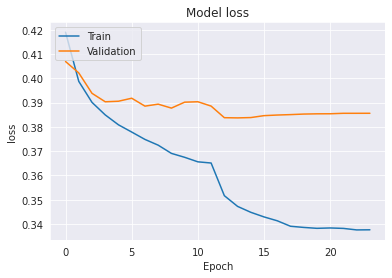

In [26]:
if is_train_enabled:
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

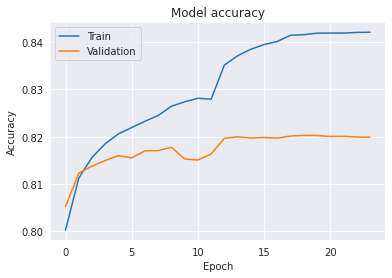

In [27]:
if is_train_enabled:
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()